In [1]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [3]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [4]:
df_games = pl.scan_parquet(game_file)

# Turn Counts

The number of turns in a game is an important metric for assessing the speed of a set. In @fig-turns-per-game, we see the distribution of turn counts for the Bloomburrow set, with an average of 8.9 turns per game.

Similar to the distribution seen in @fig-mulligan-poisson, this turn distribution appears to resemble a Poisson distribution.

In [5]:
turns = (
    df_games.group_by(["num_turns", "expansion"])
    .agg(
        pl.col("won").mean().alias("win_rate"),
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").count().alias("n_games"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="num_turns", descending=True)
)

mean_win_rate = (
    turns.group_by("expansion")
    .agg(
        pl.col("n_games").sum().alias("set_n_games"),
        pl.col("n_wins").sum().alias("set_n_wins"),
    )
    .select(
        "expansion",
        "set_n_games",
        (pl.col("set_n_wins") / pl.col("set_n_games")).alias("set_win_rate"),
    )
)

turns = (
    turns.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("set_win_rate")).alias("normalized_win_rate"),
        (pl.col("n_games") / pl.col("set_n_games")).alias("normalized_pct_games"),
    )
    .collect()
    .to_pandas()
)

filtered_turns = turns.loc[turns["pct_games"] > 0.001]
mean_win_rate = df_games.select(pl.col("num_turns").mean()).collect().to_numpy()[0][0]

turns.head()

,num_turns,expansion,win_rate,n_wins,n_games,pct_games,set_n_games,set_win_rate,normalized_win_rate,normalized_pct_games
0,33,BLB,1.0,2,2,5.214074e-07,931230,0.546025,1.831417,0.000002
1,32,BLB,0.0,0,1,2.607037e-07,931230,0.546025,0.000000,0.000001
2,32,MH3,0.0,0,1,2.607037e-07,767772,0.550959,0.000000,0.000001
3,32,MKM,0.5,1,2,5.214074e-07,964377,0.549798,0.909424,0.000002
4,32,OTJ,1.0,3,3,7.821111e-07,1172393,0.541419,1.846998,0.000003


In [6]:
df_plot = df_games.collect().to_pandas()
df_plot = df_plot[df_plot["num_turns"] < 20]

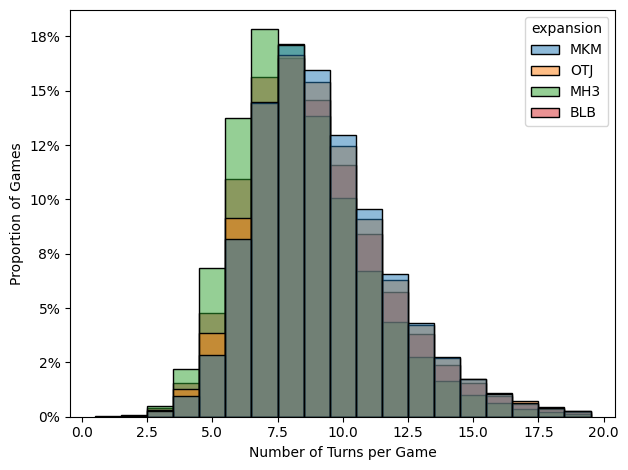

In [10]:
# | label: fig-turns-per-game
# | fig-cap: "The distribution of number of turns per game."


# sns.barplot(data=turns, x="num_turns", y="normalized_pct_games", hue="expansion")

sns.histplot(
    data=df_plot,
    x="num_turns",
    hue="expansion",
    # multiple="dodge",
    discrete=True,
    stat="probability",
    # fill=False,
    # element="step",
    alpha=0.5,
    common_norm=False,
    palette="tab10",
    # kde=True,
)
anno.set_labels_to_percent(axis="y")
# anno.plot_vert_line(x=8)
anno.set_axis_labels_and_show(
    xlabel="Number of Turns per Game",
    ylabel="Proportion of Games",
)

I'm also interested in how 17Lands players perform relative to the number of turns. In @fig-turns-wins, we observe that players are more likely to win games that end quickly. The win rate is 55-60% for games that conclude in fewer than 8 turns, dropping to 50-55% for games that last longer.

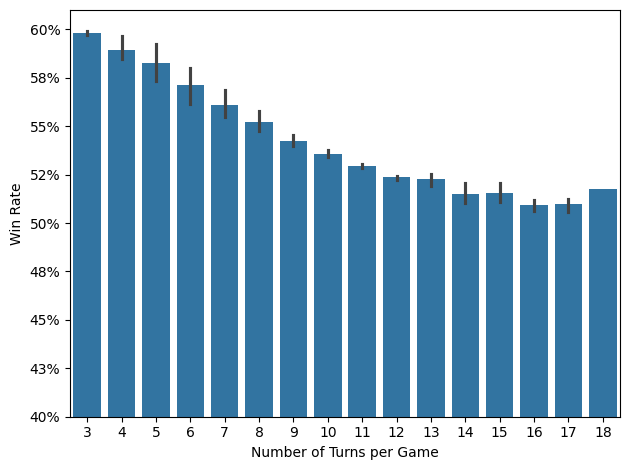

In [9]:
# | label: fig-turns-wins
# | fig-cap: "The win rate versus number of turns."

sns.barplot(data=filtered_turns, x="num_turns", y="win_rate")
plt.gca().set_ylim([0.4, 0.61])
anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Turns per Game",
    ylabel="Win Rate",
)